In [ ]:
#Simulations with fixed Sigma

In [1]:
#import of packages

import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm #matrix square root
from scipy.stats import gaussian_kde

print("ok")

ok


In [2]:
#import monte carlo skripts and plotting functions from other notebooks

import os
print(os.listdir())

%run Monte_Carlo_functions_V_1_24_2.ipynb
%run Plot_functions_V_1_24_2.ipynb

#import Plots_V_1_24_2
#Plots_V_1_24_2.addit(6,7)

print(skripts_work())
print(plots_work())

['.ipynb_checkpoints', 'Monte_Carlo_functions_V_1_24_2.ipynb', 'Plot_functions_V_1_24_2.ipynb', 'Simulation_V_1_24_2.ipynb']
ok
ok
ok
ok
ok
ok
Monte carlo skript functions integrated.
Plotting functions integrated.


In [3]:
#parameters

#testing
test=0  #on = 1, off = 0

print("ok")

ok


In [4]:
#elementary functions for generation of log-price paths


#generate QV and a denoised one
def qv_generator_with_denoiser(eigenvalues, number_vanishing_eigenvalues):
    """
    Create a random qv matrix Sigma as symmetric matrix with specified eigenvalues
    and a denoised version without the smallest number_vanishing_terms terms in the SVD.

    Parameters
    ----------
    eigenvalues : array-like
        Desired eigenvalues of the matrix.
    number_vanishing_eigenvalues : int
        How many eigenvalues are negligible in the SVD.

    Returns
    -------
    Sigma : numpy.ndarray
        Sigma matrix with given eigenvalues.
    Sigma_denoised : numpy.ndarray
        Sigma matrix which neglects the smallest number_vanishing_terms terms in the SVD.
    """
    eigenvalues = np.asarray(eigenvalues)
    d = len(eigenvalues)

    A = np.random.normal(size=(d, d))
    U, S, V_T = np.linalg.svd(A)

    D = np.diag(eigenvalues)
    Sigma = U @ D @ U.T

    eigenvalues_denoised=eigenvalues.copy()
    eigenvalues_denoised[d-number_vanishing_eigenvalues:d]=np.zeros(number_vanishing_eigenvalues)
    # denoised eigenvalues are zero on vanishing positions, attention: stop: exklusive

    D_denoised=np.diag(eigenvalues_denoised)
    Sigma_denoised=U @ D_denoised @ U.T

    return Sigma , Sigma_denoised

#generate quadratic variation with special properties on eigenvalues

def special_qv_generator(d=30, dominant_eigenvalues=1, mu_dominant=22, std_dominant=1,
                         normal_eigenvalues=2, mu_normal=7, std_normal=1, mu_vanishing=0, std_vanishing=0.1):
    """
    Create a random QV matrix Sigma as symmetric matrix with randomly chosen eigenvalues following normal distributions.
    Also return a denoised version without the vanishing components in the SVD.

    Parameters
    ----------
    d : int
        Dimenions of log-prices and number of columns and rows of Sigma.
    dominant_eigenvalues : int
        Number of dominant eigenvalues, e.g., market factor???
    mu_dominant: int
        Mean of dominant eigenvalues.
    std_dominant: int
        Standard deviation of dominant eigenvalues.
    normal_eigenvalues : int
        Number of normal eigenvalues.
        The number of small eigenvalues that vanish in the limit is: d-(dominant_eigenvalues+normal_eigenvalues).
    mu_normal: int
        Mean of normal eigenvalues.
    std_normal: int
        Standard deviation of normal eigenvalues.
    mu_vanishing: int
        Mean of vanishing eigenvalues.
    std_vanishing: int
        Standard deviation of vanishing eigenvalues.

    Returns
    -------
    Sigma : numpy.ndarray
        Sigma matrix.

    Sigma_denoised : numpy.ndarray
        Sigma matrix without components from vanishing eigenvalues.

    """
    eigenvalues = np.zeros(d)

    eigenvalues[0 : dominant_eigenvalues]=np.random.normal(loc=mu_dominant, scale=std_dominant, size=dominant_eigenvalues)

    eigenvalues[dominant_eigenvalues : dominant_eigenvalues + normal_eigenvalues]=(
        np.random.normal(loc=mu_normal, scale=std_normal, size=normal_eigenvalues))

    eigenvalues[dominant_eigenvalues + normal_eigenvalues : d]=(
        np.abs(np.random.normal(loc=mu_vanishing, scale=std_vanishing, size= d-(dominant_eigenvalues+normal_eigenvalues))))

    Sigma, Sigma_denoised = qv_generator_with_denoiser(eigenvalues, d-(dominant_eigenvalues+normal_eigenvalues))
    # denoised eigenvalues have zeros outside of dominant and normal

    return Sigma , Sigma_denoised


#generate increments fast

def fast_increments_generator(volatility, drift, sampling_interval=0.01):
    """
    Create the increments of observations along a path of log-prices induced by a fixed drift and volatility
    using the Euler-Maruyama scheme. As the calculation is vectorized, it should be fast.

    Parameters
    ----------
    volatility : numpy.ndarray
        Stochastic volatility of the Itô process.
    drift : numpy.ndarray
        Stochastic drift of the Itô process.
    sampling_interval: float
        Time diffference between observations on [o,1].

    Returns
    -------
    observed_increments : numpy.ndarray
        Matrix with the increments of the log-prices on the interval [(i-1)*sampling_interval,i*sampling_interval]
        in the i-th row.

    """

    d=volatility.shape[0]
    n=int(np.floor(1/sampling_interval))

    observed_increments=np.zeros((n,d))

    dW=np.sqrt(sampling_interval)*np.random.randn(n,d)

    diffusion= (volatility@(dW.T)).T # create a n times d matrix, each row is the diffusion vector
    drift_matrix=np.tile(sampling_interval*drift, (n,1)) # create a n times d matrix, each row is the drift vector

    observed_increments=drift_matrix+diffusion

    return observed_increments


print("ok")


ok


In [5]:
#elementary functions for estimators


#fast realized variance estimator

def fast_realized_variance(observed_increments):
    """
    Calculate realized variance Sigma_hat from log-price increments. As the calculation is vectorized, it should be fast.

    Parameters
    ----------
    observed_increments : numpy.ndarray
        Matrix with the increments of the log-prices on the interval [(i-1)*sampling_interval,i*sampling_interval]
        in the i-th row.

    Returns
    -------
    Sigma_hat : numpy.ndarray
        Matrix estimator of the underlying QV.

    """

    Sigma_hat=(observed_increments.T) @ observed_increments

    return Sigma_hat



#prv estimator if RV and lambda are known

def penalized_realized_variance_for_given_lambda_and_RV(Sigma_hat, tuning_parameter_lambda):
    """
    Calculate the PRV estimator Sigma_hat_lambda from the RV estimator and the tuning parameter lambda.

    Parameters
    ----------
    Sigma_hat : numpy.ndarray
        Realized variance estimator.
    tuning_parameter_lambda : int
        The tuning parameter lambda used as prefactor of the nuclear norm penalization.

    Returns
    -------
    Sigma_hat_lambda : numpy.ndarray
        Matrix estimator of the underlying QV.
    rank_of_prv : int
        Rank of the PRV estimator matrix.

    """
    d=Sigma_hat.shape[0]
    Sigma_hat_lambda=np.zeros((d,d))
    rank_of_prv=30 #if all shrinked eigenvalues are positive, the else below is never reached, so need rank d then

    #prv calculation (with Theorem 3.6 in the thesis)

    eigvals_rv_ascending, U = np.linalg.eigh(Sigma_hat)
    # rv symmetric, hence, it returns ascending eigvals and eigvecs in columns of U

    eigvals_rv=np.flip(eigvals_rv_ascending) #eigenvals now in descending order

    for z in range(d):
        if eigvals_rv[z]>(tuning_parameter_lambda/2):
            Sigma_hat_lambda+=(eigvals_rv[z]-(tuning_parameter_lambda/2))* ((U[:,d-z-1].reshape(d,1)) @ (U[:,d-z-1].reshape(d,1).T))
            #attention: since eigenvales are flipped, the index in U is d-z-1, not z!
        else:
            #as descending, all others are also smaller (lambda_final/2)
            rank_of_prv=z
            break


    return Sigma_hat_lambda, rank_of_prv


#subsampling procedure for the data-driven selection of lambda

def lambda_selection_via_subsampling_procedure(observed_increments, L_lambda=6):
    """
    Calculate the tuning parameter lambda_subsam by an subsmapling procedure following section 2.4 in Christensen et al. (2022).

    Parameters
    ----------
    observed_increments : numpy.ndarray
        Matrix with the increments of the log-prices on the interval [(i-1)*sampling_interval,i*sampling_interval]
        in the i-th row.
    L_lambda : int
        The hyperparameter L_lambda defines the number of subsamples used in the choice of the tuning parameter lambda.

    Returns
    -------
    lambda_subsam: float
        Tuning parameter that is applied for PRV.

    """
    n,d=observed_increments.shape
    sigma_hat_rv=fast_realized_variance(observed_increments)

    #subsampling for choice of lambda
    lambdas=np.zeros(L_lambda)

    for l in range(L_lambda):
        observed_increments_subsample=observed_increments[np.arange(l,n,L_lambda),:] #start, stop, step
        #l, l+L, l+2L,...,(n/L-1)*L+L
        subsample_rv=L_lambda*fast_realized_variance(observed_increments_subsample) #equation (2.24) in Christensen et al. (2022)
        lambdas[l]=(2/np.sqrt(L_lambda))*np.linalg.norm((subsample_rv - sigma_hat_rv), ord=2)
        #equation (2.25) in Christensen et al. (2022), spectral norm here order 2

    lambda_subsam=np.mean(lambdas) #equation (2.26) in Christensen et al. (2022)

    return lambda_subsam


print("ok")

ok


In [6]:
#fast analysis

#setup
d=30
n_standard=78
L_lambda_standard=6

factor=5  #1=paper Christensen, high implies smaller sampling interval and more subsamples
            #5=1 price per minute (normal)
            #300 = 1 price per s (maximal)
n=n_standard*factor
L_lambda=L_lambda_standard*factor

delta_n=1/n

dominant_eigenvalues=1
normal_eigenvalues=2

Sigma , Sigma_denoised =special_qv_generator(d=d, dominant_eigenvalues=dominant_eigenvalues, mu_dominant=10, std_dominant=0.5,
                                             normal_eigenvalues=normal_eigenvalues, mu_normal=5, std_normal=0.5,
                                             mu_vanishing=0, std_vanishing=0.2)

true_eigenvalues_Sigma= np.sort(np.linalg.eigh(Sigma)[0])[::-1] #sort creates increasing, now decreasing

drift=np.random.randn(1,d)

number_of_simulations=1000 #10000 for factor = 5 runs in 2 min
                            #100 for factor = 300 runs in 1 min

#monte carlo simulation
eigenvalues_rv , eigenvalues_prv , lambdas_used , rank_rv , rank_prv , all_errors=fast_monte_carlo_simulation_with_fixed_QV(
    Sigma_true=Sigma, Sigma_true_denoised=Sigma_denoised, sampling_interval=delta_n, drift=drift,
    L_lambda=L_lambda, number_of_simulations=number_of_simulations, number_error_types=12,
    progress_number=number_of_simulations/10)

print('ok')


0 simulations: finished.
100 simulations: finished.
200 simulations: finished.
300 simulations: finished.
400 simulations: finished.
500 simulations: finished.
600 simulations: finished.
700 simulations: finished.
800 simulations: finished.
900 simulations: finished.
ok


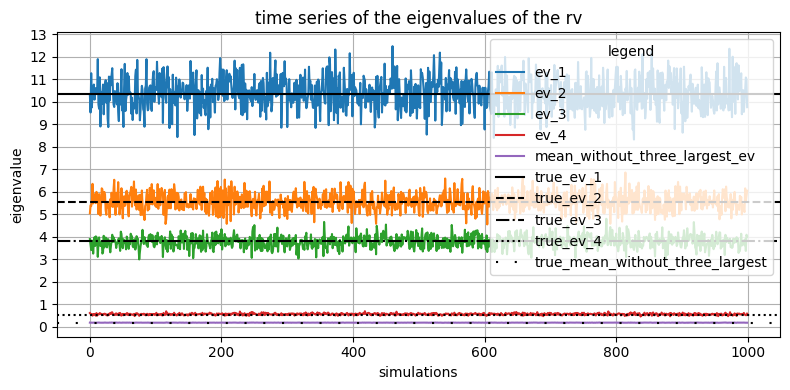

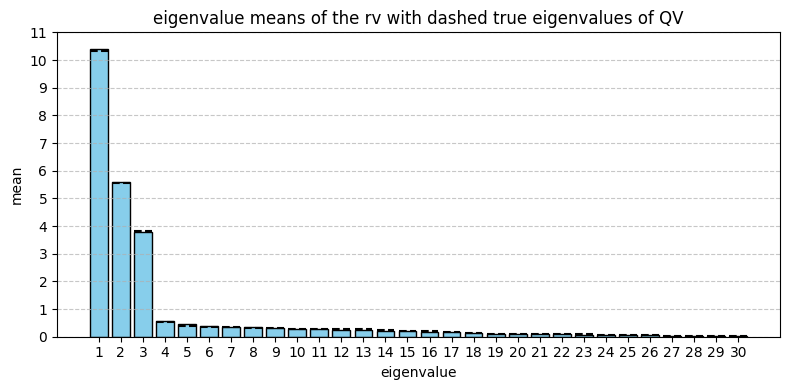

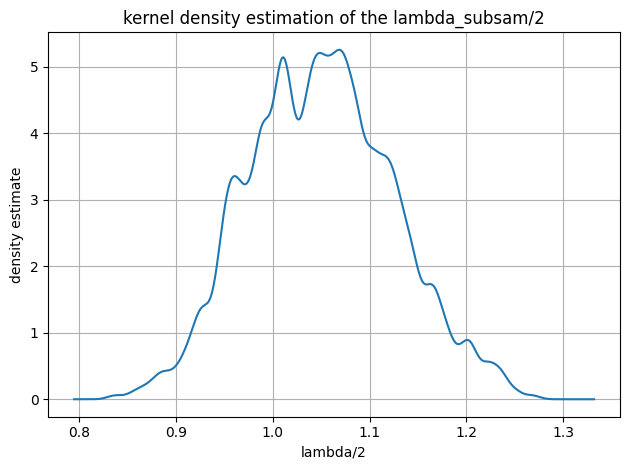

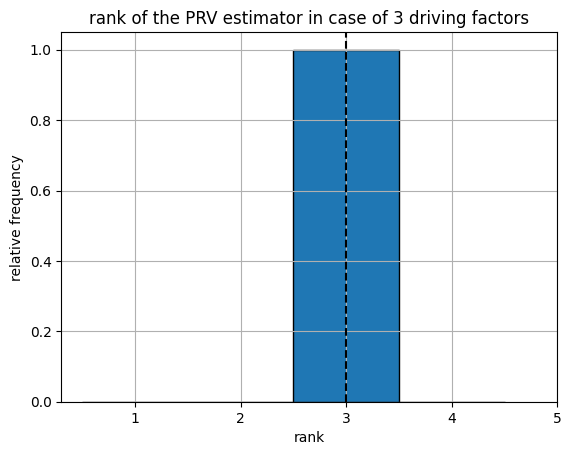

In [9]:
#plots

plot_eigenvalues_rv(eigenvalues_rv, true_eigenvalues_Sigma, title="time series of the eigenvalues of the rv", save_image=0,
                        name_of_copy="plot_eigenvalues_rv.png")
#plot_eigenvalues_rv(eigenvalues_prv, true_eigenvalues_Sigma, title="time series of the eigenvalues of the prv", save_image=0,
                        #name_of_copy="plot_eigenvalues_prv.png")
plot_means_of_eigenvalues(eigenvalues_rv, true_eigenvalues_Sigma,
                          title="eigenvalue means of the rv with dashed true eigenvalues of QV", save_image=0,
                          name_of_copy="plot_mean_eigenvalues_rv.png")
#plot_means_of_eigenvalues(eigenvalues_prv, true_eigenvalues_Sigma,
                          #title="eigenvalue means of the prv with dashed true eigenvalues of QV", save_image=0,
                          #name_of_copy="plot_mean_eigenvalues_prv.png")
kde_of_lambdas_half(lambdas_used, smoothing=0.1, title="kernel density estimation of the lambda_subsam/2", save_image=0,
                        name_of_copy="kde_of_half_of_lambda_subsam.png")
histogram_of_the_rank(rank_prv, true_rank_of_denoised_Sigma=np.linalg.matrix_rank(Sigma_denoised),
                      title="rank of the PRV estimator",
                      save_image=0, name_of_copy="histogram_rank_prv.png")
#histogram_of_the_rank(rank_rv, true_rank_of_denoised_Sigma=np.linalg.matrix_rank(Sigma_denoised),
                      #title="rank of the RV estimator",
                      #save_image=0, name_of_copy="histogram_rank_rv.png")



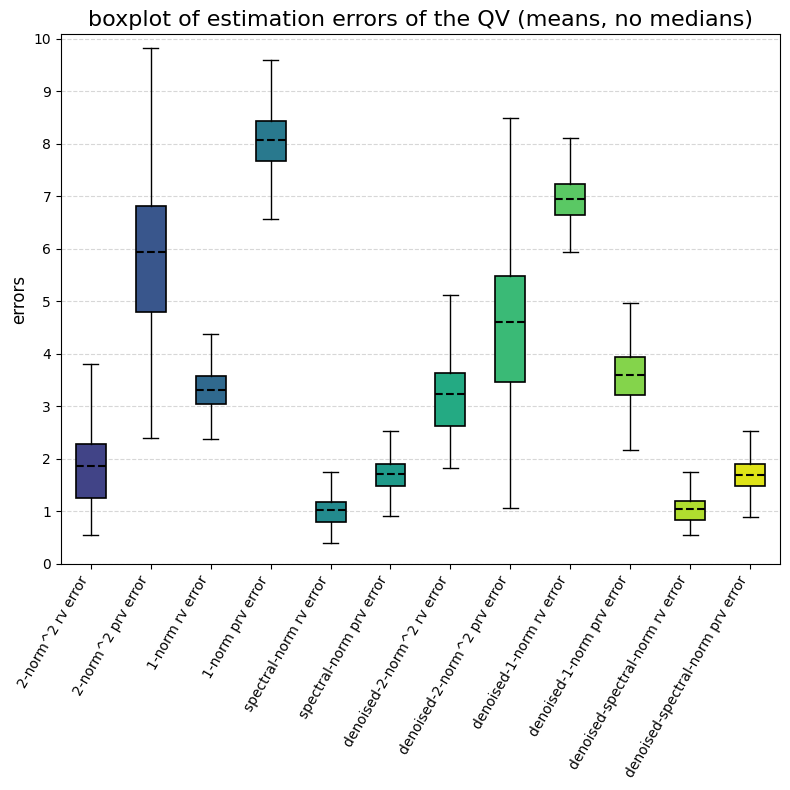

In [ ]:
boxplot_estimation_errors(all_errors, title="boxplot of estimation errors of the QV (means, no medians)", save_image=0,
                              name_of_copy="boxplot_est_errors.png")

In [105]:
#does the prv detect the rank?

#setup

mu_dominant=20 #good: 10
mu_normal=5 #good: 5
mu_vanishing=1 #good: 0

d=30
n_standard=78
L_lambda_standard=6

factor=5  #1=paper Christensen, high implies smaller sampling interval and more subsamples
            #5=1 price per minute (normal)
            #300 = 1 price per s (maximal)
n=n_standard*factor
L_lambda=L_lambda_standard*factor

delta_n=1/n

list_of_number_of_dominant_and_normal_ev_pairs=np.array([[0,0],[1,0], [2,0], [1,1],[1,2], [2,1], [1,3], 
                                                         [2,2], [3,1],[4,1], [5,1],[3,3],[6,1],[2,5], [10,1], [6,6], [7,7], 
                                                         [15,1],[10,6], [8,8],[20,1], [29,1],[30,0]])
true_underlying_ranks=list_of_number_of_dominant_and_normal_ev_pairs.sum(axis=1)
rank_prv_means=np.zeros(len(true_underlying_ranks))

for z in range(len(true_underlying_ranks)):
    dominant_eigenvalues=list_of_number_of_dominant_and_normal_ev_pairs[z,0]
    normal_eigenvalues=list_of_number_of_dominant_and_normal_ev_pairs[z,1]

    Sigma , Sigma_denoised =special_qv_generator(d=d, dominant_eigenvalues=dominant_eigenvalues, 
                                                 mu_dominant=mu_dominant, std_dominant=0.2,
                                                 normal_eigenvalues=normal_eigenvalues, mu_normal=mu_normal, std_normal=0.2,
                                                 mu_vanishing=mu_vanishing, std_vanishing=0.2)

    true_eigenvalues_Sigma= np.sort(np.linalg.eigh(Sigma)[0])[::-1] #sort creates increasing, now decreasing

    drift=np.random.randn(1,d)

    number_of_simulations=100 #1000 for factor = 5 runs in 2 min
                               

    #monte carlo simulation
    eigenvalues_rv , eigenvalues_prv , lambdas_used , rank_rv , rank_prv , all_errors=fast_monte_carlo_simulation_with_fixed_QV(
        Sigma_true=Sigma, Sigma_true_denoised=Sigma_denoised, sampling_interval=delta_n, drift=drift,
        L_lambda=L_lambda, number_of_simulations=number_of_simulations, number_error_types=12,
        progress_number=number_of_simulations)
    
    rank_prv_means[z]=np.mean(rank_prv)
    print(f'[dominant, normal]=[{list_of_number_of_dominant_and_normal_ev_pairs[z,0]}, {list_of_number_of_dominant_and_normal_ev_pairs[z,1]}] ')

print('ok')



0 simulations: finished.
[dominant, normal]=[0, 0] 
0 simulations: finished.
[dominant, normal]=[1, 0] 
0 simulations: finished.
[dominant, normal]=[2, 0] 
0 simulations: finished.
[dominant, normal]=[1, 1] 
0 simulations: finished.
[dominant, normal]=[1, 2] 
0 simulations: finished.
[dominant, normal]=[2, 1] 
0 simulations: finished.
[dominant, normal]=[1, 3] 
0 simulations: finished.
[dominant, normal]=[2, 2] 
0 simulations: finished.
[dominant, normal]=[3, 1] 
0 simulations: finished.
[dominant, normal]=[4, 1] 
0 simulations: finished.
[dominant, normal]=[5, 1] 
0 simulations: finished.
[dominant, normal]=[3, 3] 
0 simulations: finished.
[dominant, normal]=[6, 1] 
0 simulations: finished.
[dominant, normal]=[2, 5] 
0 simulations: finished.
[dominant, normal]=[10, 1] 
0 simulations: finished.
[dominant, normal]=[6, 6] 
0 simulations: finished.
[dominant, normal]=[7, 7] 
0 simulations: finished.
[dominant, normal]=[15, 1] 
0 simulations: finished.
[dominant, normal]=[10, 6] 
0 simulat

In [106]:
#print for table
print(f'For n={n}, [dominant, normal]=[x,y] and the underlying rank=z, the Monte Carlo mean of the estimated rank of the PRv is:')
for z in range(len(true_underlying_ranks)):
    print(f'[dominant, normal]=[{list_of_number_of_dominant_and_normal_ev_pairs[z,0]}, {list_of_number_of_dominant_and_normal_ev_pairs[z,1]}] and rank = {true_underlying_ranks[z]}: estimated rank = {rank_prv_means[z]} .')


For n=390, [dominant, normal]=[x,y] and the underlying rank=z, the Monte Carlo mean of the estimated rank of the PRv is:
[dominant, normal]=[0, 0] and rank = 0: estimated rank = 19.6 .
[dominant, normal]=[1, 0] and rank = 1: estimated rank = 1.22 .
[dominant, normal]=[2, 0] and rank = 2: estimated rank = 2.0 .
[dominant, normal]=[1, 1] and rank = 2: estimated rank = 2.01 .
[dominant, normal]=[1, 2] and rank = 3: estimated rank = 3.01 .
[dominant, normal]=[2, 1] and rank = 3: estimated rank = 3.0 .
[dominant, normal]=[1, 3] and rank = 4: estimated rank = 4.0 .
[dominant, normal]=[2, 2] and rank = 4: estimated rank = 4.0 .
[dominant, normal]=[3, 1] and rank = 4: estimated rank = 4.0 .
[dominant, normal]=[4, 1] and rank = 5: estimated rank = 4.99 .
[dominant, normal]=[5, 1] and rank = 6: estimated rank = 5.83 .
[dominant, normal]=[3, 3] and rank = 6: estimated rank = 6.0 .
[dominant, normal]=[6, 1] and rank = 7: estimated rank = 6.43 .
[dominant, normal]=[2, 5] and rank = 7: estimated ran

In [98]:
#results: vanishing: mu=0, std=0.2

#mu_dominant=10, mu_normal=5
    #works perfect for: mu_dominant=10, mu_normal=5, and rank in [1,14]
    #only rank=0 guessed to large (rank 15) as all ev have same level 
    #or rank>14 guessed to small, same problem actuially, some large ev cutted away...
#mu_dominant=5, mu_normal=3
    #works good for rank in [3,14], outside problems
#mu_dominant=2, mu_normal=1 
    #problems outside of [5,11], especially for a lot normals...then the ev overlap probably...



#now: vanishing mu=1 and std=0.2 (this std for all ev)

#mu_dominant=10, mu_normal=5
    #works good for rank in [4,14]
#mu_dominant=20, mu_normal=10
    #works good for rank in [1,14]
#mu_dominant=20, mu_normal=5
    #works good for rank in [1,6]




In [58]:
#fast sensitivity analysis of L_lambda

#setup
d=30
n_standard=78

factor=5  #1=paper Christensen, high implies smaller sampling interval and more subsamples
            #5=1 price per minute (normal)
            #300 = 1 price per s (maximal)
n=n_standard*factor

delta_n=1/n

dominant_eigenvalues=1
normal_eigenvalues=2

Sigma , Sigma_denoised =special_qv_generator(d=d, dominant_eigenvalues=dominant_eigenvalues, mu_dominant=10, std_dominant=0.5,
                                             normal_eigenvalues=normal_eigenvalues, mu_normal=5, std_normal=0.5,
                                             mu_vanishing=0, std_vanishing=0.5)

drift=np.random.randn(1,d)

number_of_simulations=100 #10000 for factor = 5 runs in 2 min
                            #100 for factor = 300 runs in 1 min

#monte carlo simulation
L_lambdas , lambdas_used , rank_prv , squared_2_norm_error_prv , denoised_squared_2_norm_error_prv=fast_sensitivity_analysis_for_L_lambda_with_fixed_QV(
    Sigma_true=Sigma, Sigma_true_denoised=Sigma_denoised, sampling_interval=delta_n, drift=drift,
    number_of_simulations=number_of_simulations, number_error_types=2, progress_number=number_of_simulations/10)

print('ok')


0 simulations: finished.
10 simulations: finished.
20 simulations: finished.
30 simulations: finished.
40 simulations: finished.
50 simulations: finished.
60 simulations: finished.
70 simulations: finished.
80 simulations: finished.
90 simulations: finished.
ok


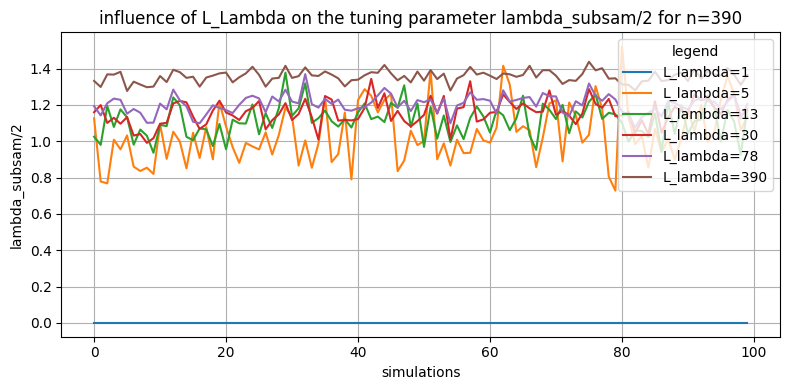

mean of lambda_subsam/2 for L_lambda=1 is: 0.0 .
mean of lambda_subsam/2 for L_lambda=5 is: 1.0381219242271953 .
mean of lambda_subsam/2 for L_lambda=13 is: 1.1135663893932515 .
mean of lambda_subsam/2 for L_lambda=30 is: 1.158025532664858 .
mean of lambda_subsam/2 for L_lambda=78 is: 1.2032374232518672 .
mean of lambda_subsam/2 for L_lambda=390 is: 1.3556744739105784 .


'\nselection_L_lambdas=L_lambdas[::3]\nselection_rank_prv=rank_prv[:,::3]\nplot_time_series_sensitivity_analysis_L_lambda(selection_rank_prv, selection_L_lambdas, number_of_observations=n,\n                                               name_y_axis="rank",\n                                               title="influence of L_Lambda on the rank of the PRV",\n                                               y_ticks_automatic=0, save_image=0,\n                                               name_of_copy="plot_rank_PRV_sensitive_L_lambda.png")\n\nselection_L_lambdas=L_lambdas[::3]\nselection_squared_2_norm_error_prv=squared_2_norm_error_prv[:,::3]\nplot_time_series_sensitivity_analysis_L_lambda(selection_squared_2_norm_error_prv, selection_L_lambdas,\n                                               number_of_observations=n, name_y_axis="error",\n                                               title="influence of L_Lambda on the squared Frobenius norm error of the PRV",\n                        

In [61]:
#plots
selection_L_lambdas=L_lambdas[::3] #only each second column is chosen for: [start : stop : step=2]
selection_lambdas_used=lambdas_used[:,::3]
plot_time_series_sensitivity_analysis_L_lambda(selection_lambdas_used/2, selection_L_lambdas, number_of_observations=n,
                                               name_y_axis="lambda_subsam/2",
                                               title="influence of L_Lambda on the tuning parameter lambda_subsam/2",
                                               y_ticks_automatic=1, save_image=0, 
                                               name_of_copy="plot_lambdas_sensitive_L_lambda.png")
#means for table
for z in range(len(selection_L_lambdas)):
    print(f'mean of lambda_subsam/2 for L_lambda={selection_L_lambdas[z]} is: {np.mean((selection_lambdas_used/2)[:,z])} .')

"""
selection_L_lambdas=L_lambdas[::3]
selection_rank_prv=rank_prv[:,::3]
plot_time_series_sensitivity_analysis_L_lambda(selection_rank_prv, selection_L_lambdas, number_of_observations=n,
                                               name_y_axis="rank",
                                               title="influence of L_Lambda on the rank of the PRV",
                                               y_ticks_automatic=0, save_image=0,
                                               name_of_copy="plot_rank_PRV_sensitive_L_lambda.png")

selection_L_lambdas=L_lambdas[::3]
selection_squared_2_norm_error_prv=squared_2_norm_error_prv[:,::3]
plot_time_series_sensitivity_analysis_L_lambda(selection_squared_2_norm_error_prv, selection_L_lambdas,
                                               number_of_observations=n, name_y_axis="error",
                                               title="influence of L_Lambda on the squared Frobenius norm error of the PRV",
                                               y_ticks_automatic=0, save_image=0,
                                               name_of_copy="plot_error_PRV_sensitive_L_lambda.png")

selection_L_lambdas=L_lambdas[::3]
selection_denoised_squared_2_norm_error_prv=denoised_squared_2_norm_error_prv[:,::3]
plot_time_series_sensitivity_analysis_L_lambda(selection_denoised_squared_2_norm_error_prv, selection_L_lambdas,
                                               number_of_observations=n, name_y_axis="error",
                                               title="influence of L_Lambda on the squared Frobenius norm denoised error of the PRV",
                                               y_ticks_automatic=0, save_image=0,
                                               name_of_copy="plot_error_denoised_PRV_sensitive_L_lambda.png")
"""

In [ ]:
#conclusion : lambda_subsam: n=78 and L=6 fits well to n=390 and L=30, where a bit more or less dones not make a big difference.
#                            However, L=1 yields RV and L=n results in a large tuning parameter, maybe PRV=0...
#             rank_prv : L=1 has full rank as RV, other almost the same.
#             errors: all L besides 1 behave quite similar. Small L smaller errors.
#consequence: 13<L<=78   is ok, so also 6 for 78 relation almost.

In [ ]:
rv=fast_realized_variance(fast_increments_generator(sqrtm(Sigma), drift, sampling_interval=0.01))
print(np.sort(np.linalg.eigh(rv)[0])[::-1])
prv, rank=penalized_realized_variance_for_given_lambda_and_RV(rv, 0)
print(rank, np.sort(np.linalg.eigh(prv)[0])[::-1])

[11.52104518  7.89609297  3.7584831   1.34625985  1.04312785  0.96534857
  0.86093574  0.7312904   0.68675772  0.66216025  0.58549658  0.53789379
  0.47606259  0.41225131  0.40156797  0.34395777  0.29917457  0.26347539
  0.25208088  0.24423953  0.20743767  0.1854779   0.17103349  0.13067814
  0.11489793  0.10321008  0.10220576  0.07036556  0.05708784  0.04031286]
30 [11.52104518  7.89609297  3.7584831   1.34625985  1.04312785  0.96534857
  0.86093574  0.7312904   0.68675772  0.66216025  0.58549658  0.53789379
  0.47606259  0.41225131  0.40156797  0.34395777  0.29917457  0.26347539
  0.25208088  0.24423953  0.20743767  0.1854779   0.17103349  0.13067814
  0.11489793  0.10321008  0.10220576  0.07036556  0.05708784  0.04031286]


In [ ]:
?penalized_realized_variance_for_given_lambda_and_RV


In [62]:
#fast sensitivity analysis of the tuning parameter lambda

#setup
d=30
n_standard=78
L_lambda_standard=6

factor=1  #1=paper Christensen, high implies smaller sampling interval and more subsamples
            #5=1 price per minute (normal)
            #300 = 1 price per s (maximal)
n=n_standard*factor
L_lambda=L_lambda_standard*factor

delta_n=1/n

dominant_eigenvalues=1
normal_eigenvalues=2

Sigma , Sigma_denoised =special_qv_generator(d=d, dominant_eigenvalues=dominant_eigenvalues, mu_dominant=10, std_dominant=0.5,
                                             normal_eigenvalues=normal_eigenvalues, mu_normal=5, std_normal=0.5,
                                             mu_vanishing=0, std_vanishing=0.1)

drift=np.random.randn(1,d)

number_of_simulations=100 #10000 for factor = 5 runs in 2 min
                            #100 for factor = 300 runs in 1 min


lambda_prefactors=np.array([0, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 10])
#monte carlo simulation
lambdas_used , rank_prv , squared_2_norm_error_prv , denoised_squared_2_norm_error_prv=fast_sensitivity_analysis_for_lambda_with_fixed_QV(
    Sigma_true=Sigma, Sigma_true_denoised=Sigma_denoised, sampling_interval=delta_n, drift=drift,
    lambda_prefactors=lambda_prefactors, L_lambda=L_lambda,
    number_of_simulations=number_of_simulations, number_error_types=2, progress_number=number_of_simulations/10)

print('ok')


0 simulations: finished.
10 simulations: finished.
20 simulations: finished.
30 simulations: finished.
40 simulations: finished.
50 simulations: finished.
60 simulations: finished.
70 simulations: finished.
80 simulations: finished.
90 simulations: finished.
ok


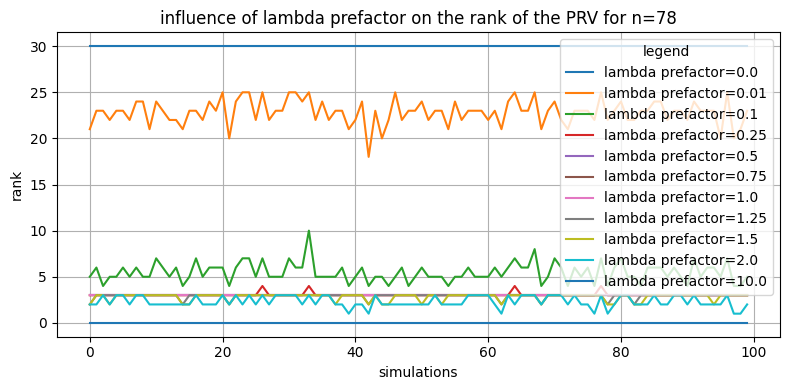

mean of rank for lambda prefactor=0.0 is: 30.0 .
mean of rank for lambda prefactor=0.01 is: 22.83 .
mean of rank for lambda prefactor=0.1 is: 5.46 .
mean of rank for lambda prefactor=0.25 is: 3.04 .
mean of rank for lambda prefactor=0.5 is: 3.0 .
mean of rank for lambda prefactor=0.75 is: 3.0 .
mean of rank for lambda prefactor=1.0 is: 3.0 .
mean of rank for lambda prefactor=1.25 is: 2.92 .
mean of rank for lambda prefactor=1.5 is: 2.82 .
mean of rank for lambda prefactor=2.0 is: 2.32 .
mean of rank for lambda prefactor=10.0 is: 0.0 .


'\nselection_lambda_prefactors=lambda_prefactors[0:len(lambda_prefactors)-2] #only each second column is chosen: [start : stop : step=2]\nselection_squared_2_norm_error_prv=squared_2_norm_error_prv[0:len(lambda_prefactors)-2]\nplot_time_series_sensitivity_analysis_lambda_prefactors(selection_squared_2_norm_error_prv, selection_lambda_prefactors,\n                                               number_of_observations=n, name_y_axis="error",\n                                               title="influence of lambda prefactor on the squared Frobenius norm error of the PRV",\n                                               y_ticks_automatic=1, save_image=0,\n                                               name_of_copy="plot_error_PRV_sensitive_lambda.png")\n\nselection_lambda_prefactors=lambda_prefactors[0:len(lambda_prefactors)-2] #only each second column is chosen: [start : stop : step=2]\nselection_denoised_squared_2_norm_error_prv=denoised_squared_2_norm_error_prv[0:len(lambda_prefactors)

In [64]:
#plots
"""
selection_lambda_prefactors=lambda_prefactors #only each second column is chosen: [start : stop : step=2]
selection_lambdas_used=lambdas_used
plot_time_series_sensitivity_analysis_lambda_prefactors(selection_lambdas_used/2, selection_lambda_prefactors,
                                                        number_of_observations=n, name_y_axis="lambda_subsam/2",
                                                        title="influence of lambda prefactor on the tuning parameter lambda_subsam/2",
                                                        y_ticks_automatic=1, save_image=0,
                                                        name_of_copy="plot_lambdas_sensitive_lambda.png")
"""
selection_lambda_prefactors=lambda_prefactors #only each second column is chosen: [start : stop : step=2]
selection_rank_prv=rank_prv
plot_time_series_sensitivity_analysis_lambda_prefactors(selection_rank_prv, selection_lambda_prefactors, number_of_observations=n,
                                                name_y_axis="rank",title="influence of lambda prefactor on the rank of the PRV",
                                                y_ticks_automatic=1, save_image=0,
                                               name_of_copy="plot_rank_PRV_sensitive_lambda.png")
#means for table
for z in range(len(selection_lambda_prefactors)):
    print(f'mean of rank for lambda prefactor={selection_lambda_prefactors[z]} is: {np.mean((selection_rank_prv)[:,z])} .')


"""
selection_lambda_prefactors=lambda_prefactors[0:len(lambda_prefactors)-2] #only each second column is chosen: [start : stop : step=2]
selection_squared_2_norm_error_prv=squared_2_norm_error_prv[0:len(lambda_prefactors)-2]
plot_time_series_sensitivity_analysis_lambda_prefactors(selection_squared_2_norm_error_prv, selection_lambda_prefactors,
                                               number_of_observations=n, name_y_axis="error",
                                               title="influence of lambda prefactor on the squared Frobenius norm error of the PRV",
                                               y_ticks_automatic=1, save_image=0,
                                               name_of_copy="plot_error_PRV_sensitive_lambda.png")

selection_lambda_prefactors=lambda_prefactors[0:len(lambda_prefactors)-2] #only each second column is chosen: [start : stop : step=2]
selection_denoised_squared_2_norm_error_prv=denoised_squared_2_norm_error_prv[0:len(lambda_prefactors)-2]
plot_time_series_sensitivity_analysis_lambda_prefactors(selection_denoised_squared_2_norm_error_prv, selection_lambda_prefactors,
                                               number_of_observations=n,  name_y_axis="error",
                                               title="influence of lambda prefactor on the squared Frobenius norm denoised error of the PRV",
                                               y_ticks_automatic=1, save_image=0,
                                               name_of_copy="plot_error_denoised_PRV_sensitive_lambda.png")
"""

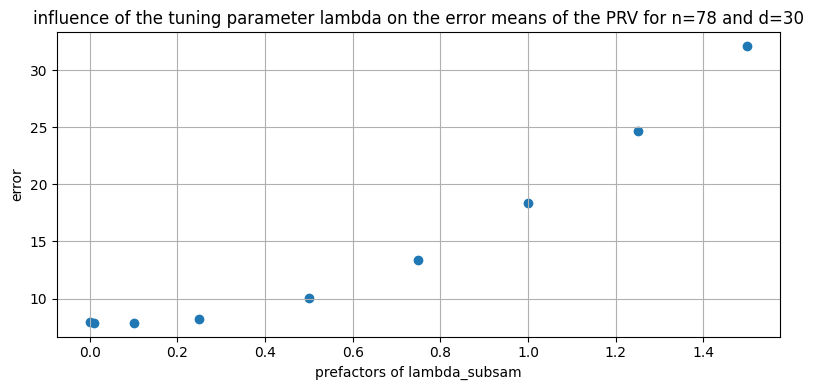

In [65]:
#plot of mean error
selection_lambda_prefactors=lambda_prefactors[0:len(lambda_prefactors)-2] #only each second column is chosen: [start : stop : step=2]
selection_squared_2_norm_error_prv=squared_2_norm_error_prv[:,0:len(lambda_prefactors)-2]
plot_mean_of_errors_sensitivity_analysis_lambda_prefactors(selection_squared_2_norm_error_prv, selection_lambda_prefactors, number_of_observations=n,
                                                            name_y_axis="error" ,
                                                            title="influence of the tuning parameter lambda on the error means of the PRV",
                                                            y_ticks_automatic=1, save_image=0,
                                                            name_of_copy="scatter_plot_error_means_PRV_sensitive_lambda.png")

In [ ]:
#conclusion: in the typical settings with n>d lambda is chosen to big in terms of the Frobenius error. Actually, rv good (maybe even best) choice.
#            But, if the rank is considered, penalization and PRV makes sense. If the rank is the goal, PRV works.

In [ ]:
selection_lambda_prefactors

array([0.01, 0.1 , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 2.  ])

In [ ]:
lambdas_used[1,:]

array([ 0.02171504,  0.21715036,  0.54287591,  1.08575181,  1.62862772,
        2.17150363,  2.71437954,  3.25725544,  4.34300726, 10.85751814,
       21.71503629])

In [ ]:
#######################################################################################
#hier Bias Variance Decomposition with best choice = PRV
#######################################################################################

0 simulations: finished.
10 simulations: finished.
20 simulations: finished.
30 simulations: finished.
40 simulations: finished.
50 simulations: finished.
60 simulations: finished.
70 simulations: finished.
80 simulations: finished.
90 simulations: finished.


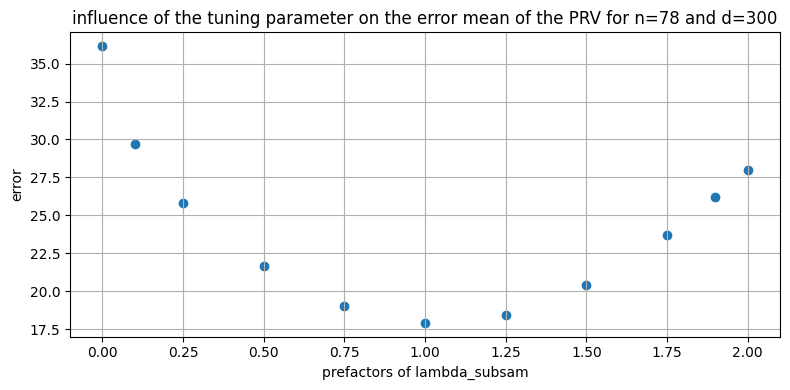

ok


In [ ]:
#fast sensitivity analysis of the tuning parameter lambda
#!!!takes around 5 min to run!!!


#setup
d=30*10 # high dimesnional setting with d > n , only 1 driving factor, others noise
n_standard=78
L_lambda_standard=6

factor=1  #1=paper Christensen, high implies smaller sampling interval and more subsamples
            #5=1 price per minute (normal)
            #300 = 1 price per s (maximal)
n=n_standard*factor
L_lambda=L_lambda_standard*factor

delta_n=1/n

dominant_eigenvalues=1
normal_eigenvalues=0

Sigma , Sigma_denoised =special_qv_generator(d=d, dominant_eigenvalues=dominant_eigenvalues, mu_dominant=10, std_dominant=0.5,
                                             normal_eigenvalues=normal_eigenvalues, mu_normal=5, std_normal=0.5,
                                             mu_vanishing=0, std_vanishing=0.1)

drift=np.random.randn(1,d)

number_of_simulations=100 #1000 for factor = 1 and d=300 runs in 5 min
                        #100 for factor = 1 and d=300 runs 1 min


lambda_prefactors=np.array([0, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75 , 1.9, 2])

#monte carlo simulation
lambdas_used , rank_prv , squared_2_norm_error_prv , denoised_squared_2_norm_error_prv=fast_sensitivity_analysis_for_lambda_with_fixed_QV(
    Sigma_true=Sigma, Sigma_true_denoised=Sigma_denoised, sampling_interval=delta_n, drift=drift,
    lambda_prefactors=lambda_prefactors, L_lambda=L_lambda,
    number_of_simulations=number_of_simulations, number_error_types=2, progress_number=number_of_simulations/10)

#plot

selection_lambda_prefactors=lambda_prefactors[0:len(lambda_prefactors)-0] #only each second column is chosen: [start : stop : step=2]
selection_squared_2_norm_error_prv=squared_2_norm_error_prv[:,0:len(lambda_prefactors)-0]
plot_mean_of_errors_sensitivity_analysis_lambda_prefactors(selection_squared_2_norm_error_prv, selection_lambda_prefactors, number_of_observations=n,
                                                            dimension=d, name_y_axis="error" ,
                                                            title="influence of the tuning parameter on the error mean of the PRV",
                                                            y_ticks_automatic=1, save_image=1,
                                                            name_of_copy="bias_variance_decomposition_scatter_plot_error_means_PRV_sensitive_lambda.png")
print('ok')


In [ ]:
#######################################################################################
#ab hier erste Versuche zur Implementierung der theoretical findings
#######################################################################################

In [ ]:
#comparison with Th 4.7

#tests if theoretical lambdas work

#setup
d=30
n_standard=78
L_lambda_standard=6

factor=5  #1=paper Christensen, high implies smaller sampling interval and more subsamples
            #5=1 price per minute (normal)
            #300 = 1 price per s (maximal)
n=n_standard*factor
L_lambda=L_lambda_standard*factor

delta_n=1/n

dominant_eigenvalues=1
normal_eigenvalues=2

Sigma , Sigma_denoised =special_qv_generator(d=d, dominant_eigenvalues=dominant_eigenvalues, mu_dominant=10, std_dominant=0.5,
                                             normal_eigenvalues=normal_eigenvalues, mu_normal=5, std_normal=0.5,
                                             mu_vanishing=0, std_vanishing=0.2)

true_eigenvalues_Sigma= np.sort(np.linalg.eigh(Sigma)[0])[::-1] #sort creates increasing, now decreasing

drift=np.random.randn(1,d)

#parameters
tau=np.log(6*d)
gamma= 82*10**(6)
v_mu=np.linalg.norm(drift)**2
v_c_2=np.trace(Sigma)
v_c_2_old=np.linalg.norm(sqrtm(Sigma), 'fro')**2   # 'fro' is Frobenius norm
v_c_inf=np.linalg.norm(Sigma, 2)   # 2 is spectral norm
#print(v_c_2_old, v_c_2)
#v_c_2 works with old or new formnula: check!
d=Sigma.shape[0]
sampling_interval=delta_n


#lambda_esterr
print(lambda_esterr_calculation(Sigma=Sigma, drift=drift, sampling_interval=delta_n, tau=np.log(6*d), gamma= 82*10**(6)))


'''
print(20*(v_c_2*v_mu*sampling_interval)/v_c_inf, 20*(v_c_2*v_mu*sampling_interval)**0.5,
                     ((4*gamma*(tau+np.log(6*d)))*(v_c_2*v_c_inf*sampling_interval))**0.5,
                     (2*gamma/2255)*(tau+np.log(6*d))*v_c_2*sampling_interval)
'''
#index return works: check!



#lambda_conint
alpha=0.05

print(lambda_conint_calculation(Sigma=Sigma, drift=drift, sampling_interval=delta_n, alpha=0.05, gamma= 82*10**(6)))

'''
print(20*(v_c_2*v_mu*sampling_interval)**0.5,
                     ((4*gamma*np.log(6*d/alpha))*(v_c_2*v_c_inf*sampling_interval))**0.5,
                      20*(v_c_2*v_mu*sampling_interval)/v_c_inf,
                     (2*gamma/2255)*np.log(6*d/alpha)*v_c_2*sampling_interval)
'''
#index return works: check!

#dominant terms decomposed:
#print((2*gamma/2255),(tau+np.log(6*d)), v_c_2, sampling_interval)
#(2*gamma/2255)>72727 is dominant!!!
#print(4*gamma, np.log(6*d/alpha), v_c_2*v_c_inf, sampling_interval)
#4*gamma dominant

#problem: gamma to big, hence lambdas to big!!!
print('ok')

(46728.793312030495, 3)
(41447.62410272543, 1)
ok


In [54]:
#illustration of theory via monte carlo simulations

#setup
d=30
n_standard=78
L_lambda_standard=6

factor=300  #1=paper Christensen, high implies smaller sampling interval and more subsamples
            #5=1 price per minute (normal)
            #300 = 1 price per s (maximal)
n=n_standard*factor
L_lambda=L_lambda_standard*factor

delta_n=1/n

dominant_eigenvalues=1
normal_eigenvalues=2

size_correction_v_c_2=10**(-2)

Sigma , Sigma_denoised =special_qv_generator(d=d, dominant_eigenvalues=dominant_eigenvalues, mu_dominant=10*size_correction_v_c_2, std_dominant=0.5*size_correction_v_c_2,
                                             normal_eigenvalues=normal_eigenvalues, mu_normal=5*size_correction_v_c_2, std_normal=0.5*size_correction_v_c_2,
                                             mu_vanishing=0, std_vanishing=0.2*size_correction_v_c_2)

true_eigenvalues_Sigma= np.sort(np.linalg.eigh(Sigma)[0])[::-1] #sort creates increasing, now decreasing

drift=np.random.randn(1,d)

number_of_simulations=10 #10000 for factor = 5 runs in 2 min
                            #100 for factor = 300 runs in 1 min


#lambdas
gamma= 82*10**(6)  # normal: 82*10**(6)
tau=np.log(6*d)
alpha=0.05

#is n big enough?
print(f'n={n} needs to fulfill for condition (4.137) of Theorem 4.8: n > 870*v_c_2={870*np.trace(Sigma)}')

#monte carlo simulation

(lambdas_subsam_used, lambda_esterr, index_of_maximal_value_esterr, lambda_conint, index_of_maximal_value_conint,
 eigenvalues_rv , eigenvalues_prv_subsam , eigenvalues_prv_esterr , eigenvalues_prv_conint ,
 rank_rv , rank_prv , all_errors)=monte_carlo_simulation_for_theory(Sigma, Sigma_denoised,
                                                                    sampling_interval=delta_n, drift=drift, tau=tau, L_lambda=L_lambda,
                                                                    alpha=alpha, gamma= gamma,
                                                                    number_of_simulations=number_of_simulations,
                                                                    number_error_types=12,
                                                                    progress_number=number_of_simulations/10)
fro_norm=np.linalg.norm(Sigma, 'fro')**2
print(f'Squared Frobenius norm of Sigma: {fro_norm} .')


print('ok')

n=23400 needs to fulfill for condition (4.137) of Theorem 4.8: n > 870*v_c_2=224.4354112103144
0 simulations: finished.
1 simulations: finished.
2 simulations: finished.
3 simulations: finished.
4 simulations: finished.
5 simulations: finished.
6 simulations: finished.
7 simulations: finished.
8 simulations: finished.
9 simulations: finished.
Squared Frobenius norm of Sigma: 0.015661407196897764 .
ok


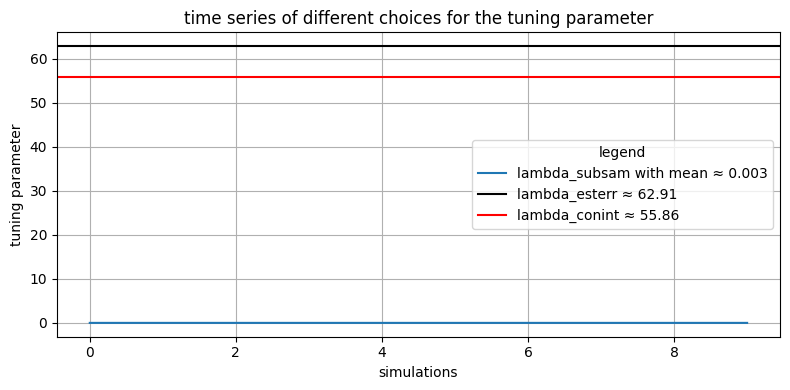

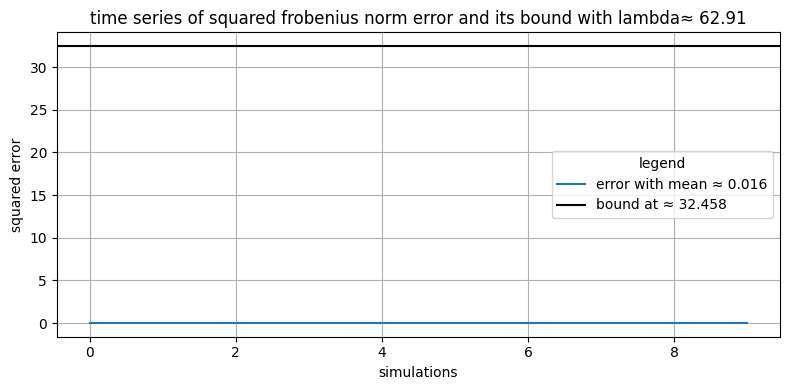

first argument in minimum of the bound is: 2*62.909661738965674*0.25797173702334986 .


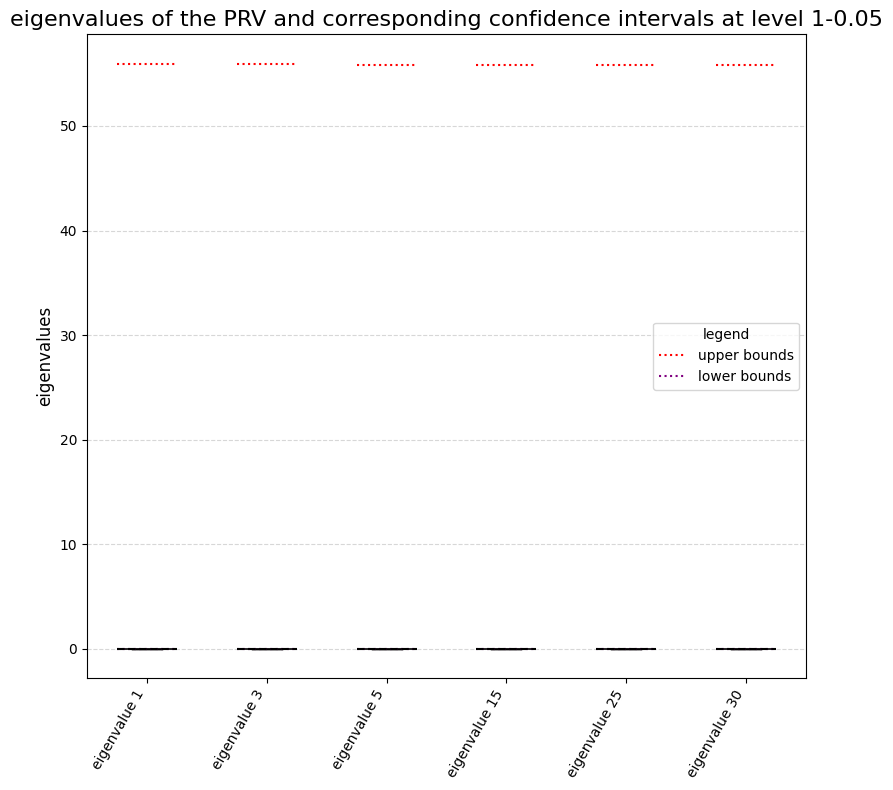

lambda_conint=55.86016151900797
ok


In [55]:
#plots


#different lambdas
plot_lambda_choices(lambdas_subsam_used, lambda_esterr, lambda_conint,
                        title="time series of different choices for the tuning parameter",
                                                      save_image=0,
                                                      name_of_copy="plot_different_lambda_choices.png")

#squared Frobenius norm error and its bound from Theorem 4.8
bound_theorem_4_8=min(2*lambda_esterr*np.linalg.norm(Sigma, 'nuc'), 3*lambda_esterr**(2)*np.linalg.matrix_rank(Sigma))
plot_bound_of_squared_frobenius_error_theorem_4_8(squared_frobenius_errors=all_errors[:,2],
                                                  bound=bound_theorem_4_8, lambda_esterr=lambda_esterr,
                                                  title="time series of squared frobenius norm error and its bound",
                                                  save_image=0,
                                                  name_of_copy="plot_error_bound_theorem_4_8.png")
nuc_norm=np.linalg.norm(Sigma, 'nuc')
print(f'first argument in minimum of the bound is: 2*{lambda_esterr}*{nuc_norm} .')


#confidence for the eigenvalues of the PRV
indices_of_plotted_eigenvalues=np.array([1,3,5,15,25,d])
#prv with lambda_conint
boxplot_eigenvalues_confidence(eigenvalues_prv=eigenvalues_prv_conint, indices_of_plotted_eigenvalues=indices_of_plotted_eigenvalues,
                               Sigma=Sigma, lambda_used=lambda_conint,
                               title=f'eigenvalues of the PRV and corresponding confidence intervals at level 1-{alpha}',
                               save_image=0,
                               name_of_copy="plot_eigenvalues_confidence_theorem_5_3.png")

print(f'lambda_conint={lambda_conint}')
'''
#prv with lambda_subsam
boxplot_eigenvalues_confidence(eigenvalues_prv=eigenvalues_prv_subsam, indices_of_plotted_eigenvalues=indices_of_plotted_eigenvalues,
                               Sigma=Sigma, lambda_used=np.mean(lambdas_subsam_used),
                               title=f'eigenvalues of the PRV and corresponding confidence intervals at level 1-{alpha}',
                               save_image=0,
                               name_of_copy="plot_eigenvalues_confidence_theorem_5_3.png")
                               
'''

print('ok')

In [ ]:
#bound is correct, but really not sharp!!!
#is delta_n large enough? 870 v_c_2=870*np.linalg.norm(Sigma, 'fro')**2
#-> smaller size of Sigma with size_correction_v_c_2=10**(-2)



In [ ]:
#####################################################################################
#old
#####################################################################################

In [ ]:
#comparison with Th 4.7

#setup
d_standard=30 #standard 30 in paper
n_standard=78
L_lambda_standard=6

factor=100  #1=paper Christensen, high implies smaller sampling interval and more subsamples
factor_d=1  #not 1, then needs much time

n=n_standard*factor
L_lambda=L_lambda_standard*factor
d=d_standard*factor_d

delta_n=1/n

dominant_eigenvalues=1
normal_eigenvalues=1
eigenvalue_size_factor= 10**(-2) #1 standard, small to reduce v_c_2 and so on

Sigma , Sigma_denoised =special_qv_generator(d=d, dominant_eigenvalues=dominant_eigenvalues,
                                             mu_dominant=10*eigenvalue_size_factor,std_dominant=0.5*eigenvalue_size_factor,
                                             normal_eigenvalues=normal_eigenvalues,
                                             mu_normal=5*eigenvalue_size_factor, std_normal=0.5*eigenvalue_size_factor,
                                             mu_vanishing=0*eigenvalue_size_factor, std_vanishing=0.5*eigenvalue_size_factor)
drift=np.random.randn(1,d)

number_of_simulations=10

#monte carlo simulation
eigenvalues_rv , eigenvalues_prv , lambdas_used , rank_rv , rank_prv , all_errors=fast_monte_carlo_simulation_with_fixed_QV(
    Sigma_true=Sigma, Sigma_true_denoised=Sigma_denoised, sampling_interval=delta_n, drift=drift,
    L_lambda=L_lambda, number_of_simulations=number_of_simulations, number_error_types=12,
    progress_number=number_of_simulations/10)

spectral_norm_error_rv=all_errors[:,5]

print('ok')

0 simulations: finished.
1 simulations: finished.
2 simulations: finished.
3 simulations: finished.
4 simulations: finished.
5 simulations: finished.
6 simulations: finished.
7 simulations: finished.
8 simulations: finished.
9 simulations: finished.
ok


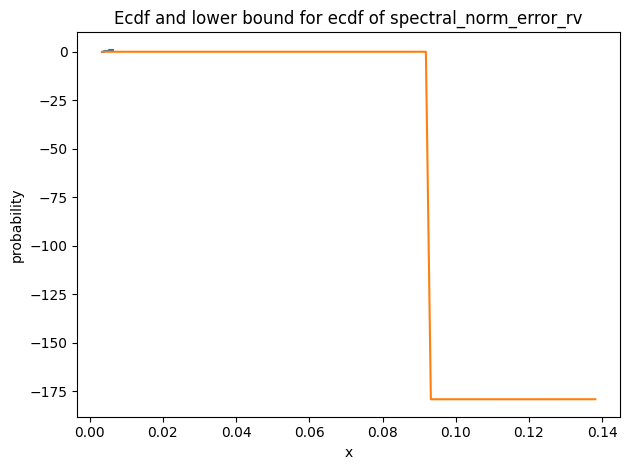

In [ ]:
#plot:


#ecdf
spectral_norm_error_rv_sorted = np.sort(spectral_norm_error_rv)
ecdf = np.arange(1, number_of_simulations + 1) / number_of_simulations


#plot for Th 4.7 bounds
gamma=82*10**(6)
v_mu=np.linalg.norm(drift)**2
v_c_2=np.linalg.norm(sqrtm(Sigma), 'fro')**2
v_c_inf=np.linalg.norm(Sigma, 2)
d=Sigma.shape[0]

def concentration_inequality_rv(x, d, v_mu, v_c_2, v_c_inf, delta_n, gamma):

    y=1-6*d*np.exp(((-1)*x/(gamma*v_c_2*v_c_inf*delta_n))* np.minimum(x, 2255*v_c_inf))

    x_min=10*max((v_c_2*v_mu*delta_n)/v_c_inf,(v_c_2*v_c_inf*delta_n)**0.5, v_c_inf*delta_n)
    y[x<x_min]=0  #inequality in Th 4.7 yields lower bound of distribution function
    return np.array(y)

x_min=10*max((v_c_2*v_mu*delta_n)/v_c_inf,(v_c_2*v_c_inf*delta_n)**0.5, v_c_inf*delta_n)
#print(x_min, (v_c_2*v_mu*delta_n)/v_c_inf,(v_c_2*v_c_inf*delta_n)**0.5, v_c_inf*delta_n)
#problem, x_min viel zu groß
x=np.linspace(min(np.min(spectral_norm_error_rv), x_min), max(np.max(spectral_norm_error_rv),1.5*x_min),
              max(100,5*number_of_simulations)) #at least 100 data points evenly spaced in interval
dist_bounds_concentration_inequality_rv=concentration_inequality_rv(x, d, v_mu, v_c_2, v_c_inf, delta_n, gamma)
#print(x, dist_bounds_concentration_inequality_rv)



#plot
plt.figure()
plt.step(spectral_norm_error_rv_sorted, ecdf, where="post", label = "lower bound on ecdf")
#post means: ecdf[i] is taken in [spectral_norm_error_rv_sorted[i], spectral_norm_error_rv_sorted[i+1])
plt.plot(x, dist_bounds_concentration_inequality_rv, label="ecdf of spectral_norm_error_rv")

plt.xlabel("x")
plt.ylabel("probability")



plt.title("Ecdf and lower bound for ecdf of spectral_norm_error_rv")



plt.tight_layout()
plt.show()

n=7800, needs > 250.9270722845529, x_min=0.09208338880457614


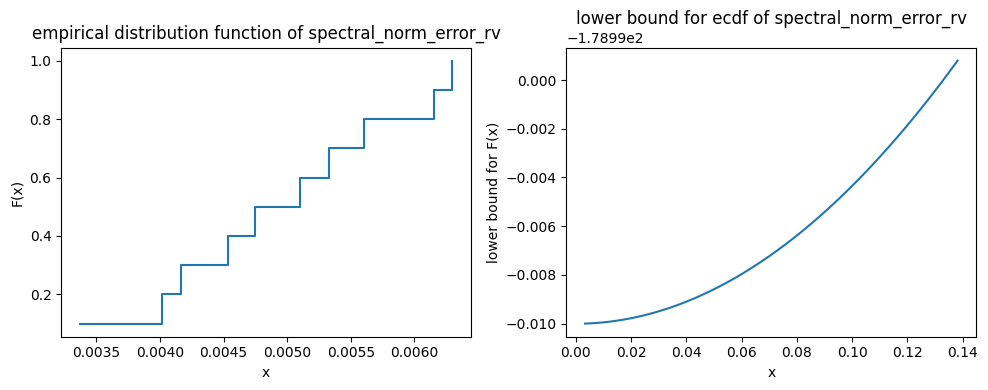

In [ ]:
#plot

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

#ecdf
spectral_norm_error_rv_sorted = np.sort(spectral_norm_error_rv)
ecdf = np.arange(1, number_of_simulations + 1) / number_of_simulations

axes[0].step(spectral_norm_error_rv_sorted, ecdf, where="post")
#post means: ecdf[i] is taken in [spectral_norm_error_rv_sorted[i], spectral_norm_error_rv_sorted[i+1])
axes[0].set_xlabel("x")
axes[0].set_ylabel("F(x)")
axes[0].set_title("empirical distribution function of spectral_norm_error_rv")

#plot for Th 4.7 bounds
gamma=82*10**(6)
v_mu=np.linalg.norm(drift)**2
v_c_2=np.linalg.norm(sqrtm(Sigma), 'fro')**2
v_c_inf=np.linalg.norm(Sigma, 2)
d=Sigma.shape[0]

def concentration_inequality_rv(x, d, v_mu, v_c_2, v_c_inf, delta_n, gamma):

    y=1-6*d*np.exp(((-1)*x/(gamma*v_c_2*v_c_inf*delta_n))* np.minimum(x, 2255*v_c_inf))

    x_min=10*max((v_c_2*v_mu*delta_n)/v_c_inf,(v_c_2*v_c_inf*delta_n)**0.5, v_c_inf*delta_n)
    #y[x<x_min]=0  #inequality in Th 4.7 yields lower bound of distribution function
    return np.array(y)

x_min=10*max((v_c_2*v_mu*delta_n)/v_c_inf,(v_c_2*v_c_inf*delta_n)**0.5, v_c_inf*delta_n)
#print(x_min, (v_c_2*v_mu*delta_n)/v_c_inf,(v_c_2*v_c_inf*delta_n)**0.5, v_c_inf*delta_n)
#problem, x_min viel zu groß

x=np.linspace(min(np.min(spectral_norm_error_rv), x_min), max(np.max(spectral_norm_error_rv),1.5*x_min),
              max(100,5*number_of_simulations)) #at least 100 data points evenly spaced in interval
dist_bounds_concentration_inequality_rv=concentration_inequality_rv(x, d, v_mu, v_c_2, v_c_inf, delta_n, gamma)
#print(x, dist_bounds_concentration_inequality_rv)

axes[1].plot(x, dist_bounds_concentration_inequality_rv)
axes[1].set_xlabel("x")
axes[1].set_ylabel("lower bound for F(x)")
axes[1].set_title("lower bound for ecdf of spectral_norm_error_rv")

print(f'n={n}, needs > {870*v_c_2}, x_min={x_min}')

plt.tight_layout()
plt.show()

In [ ]:
#######################################################################################
#ab hier nur noch testing
#######################################################################################

In [ ]:
#ask for information about object or function
#?fast_realized_variance
#?all_errors

#squared_2_norm_error_rv , squared_2_norm_error_prv , 1_norm_error_rv , 1_norm_error_prv ,
#spectral_norm_error_rv , spectral_norm_error_prv ,
#denoised_squared_2_norm_error_rv , denoised_squared_2_norm_error_prv ,
#denoised_1_norm_error_rv , denoised_1_norm_error_prv , denoised_spectral_norm_error_rv , spectral_norm_error_prv